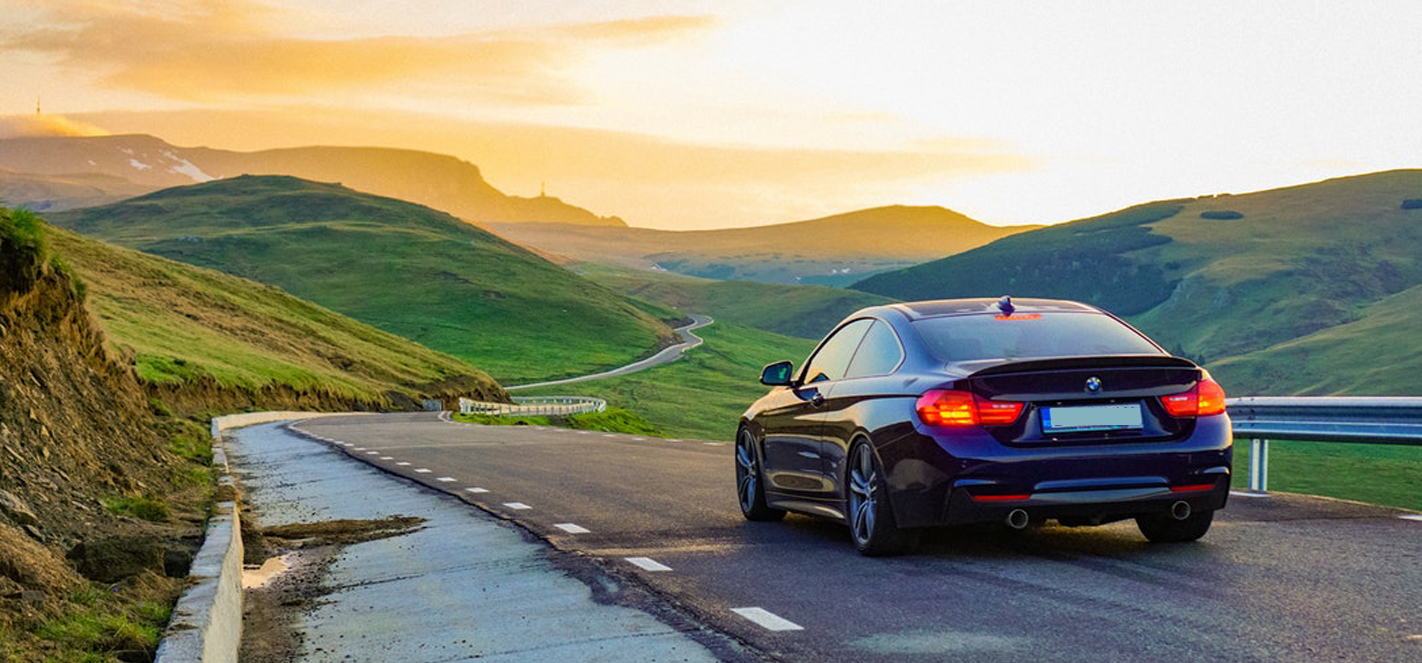

# Business Problem 

Used Car Lot TM is a used car sales company running for 2 years as a local business in India. 
The General Manager has requested some information about relative purchases of second hand vehicles in the region. 
With fuel prices increasing and transport remaining to be a dominant necessity, some important business questions were asked. 

1. What regions in India sold the highest number of used cars? 

2. Does the fuel type affect the car price? 

3. Elaborate on electric cars and do they make an impact on a sales? 

4. What are some other factors that share a connection to sales prices?   


From this analysis we intend on building a multiple linear regression (OLS) to model the relationships between the independant price and the dependant remaining variables in this dataset. 
The Used Car Lot intends on using the insights extracted to ensure their business prosperity and overall sales objectives are met proportionally. 
The information obtained will also be used to educate their sales team and help the business thrive. 

# Step 1: Read the dataset and inspect its contents

In [1]:
#Import packages
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import random
from math import sqrt
import seaborn as sns
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn')

In [2]:
#REview the dataset 
df = pd.read_csv('data\\used_cars_data.csv')

In [3]:
#load the first rows
df.head() 

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
#dropping the first column 
df.drop(['S.No.'],axis=1,inplace=True) 

In [5]:
#dropping the S.No column
df.drop(["New_Price"],axis=1,inplace=True)

In [6]:
#specify data columns with null values to remove 
from scipy.stats import norm
num_col = df.select_dtypes(include=np.number).columns.tolist()

for col in num_col:
    df[col]=df[col].replace(0.0,np.nan)

In [7]:
#list categorical columns
num_col

['Year', 'Kilometers_Driven', 'Seats', 'Price']

In [8]:
#the loop will add all the columns we want to change obj to string
# to use for a list 
num_values = []

for colname in df.columns[df.dtypes == 'object']:  # only need to focus on strings
    if df[colname].str.endswith('pl').any() or df[colname].str.endswith('kg').any() or df[colname].str.endswith('CC').any() or df[colname].str.endswith('bhp').any() or df[colname].str.endswith('Lakh').any():  
        # using `.str` to use an element-wise string method to select the required columns
        num_values.append(colname)
    
print(num_values)

['Mileage', 'Engine', 'Power']


In [9]:
#Formulating a function to splitstring from the numerical values in the columns
## also drops the string and converts to float (see data head for values)
def obj_to_num(n):
    if isinstance(n,str): #checks if the column is a string
        if n.endswith('kmpl'):
            return float(n.split('kmpl')[0])     
        elif n.endswith('km/kg'):                   
            return float(n.split('km/kg')[0])
        elif n.endswith('CC'):
            return float(n.split('CC')[0])
        elif n.startswith('null'):     #changes str values from 'null bhp' to Nan
            return(np.nan)          
        elif n.endswith('bhp'):
             return float(n.split('bhp')[0])
    else: 
        return np.nan

for colname in num_values:
    df[colname] = df[colname].apply(obj_to_num)#applying above function to the column list    
    df[colname]=df[colname].replace(0.0,np.nan)

In [10]:
#Creating category
df["Name"]=df["Name"].astype("category")
df["Location"]=df["Location"].astype("category")
df["Fuel_Type"]=df["Fuel_Type"].astype("category")
df["Transmission"]=df["Transmission"].astype("category")
df["Owner_Type"]=df["Owner_Type"].astype("category") 

In [11]:
#checking dataset for non-null values, types, totals 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               7253 non-null   category
 1   Location           7253 non-null   category
 2   Year               7253 non-null   int64   
 3   Kilometers_Driven  7253 non-null   int64   
 4   Fuel_Type          7253 non-null   category
 5   Transmission       7253 non-null   category
 6   Owner_Type         7253 non-null   category
 7   Mileage            7170 non-null   float64 
 8   Engine             7207 non-null   float64 
 9   Power              7078 non-null   float64 
 10  Seats              7199 non-null   float64 
 11  Price              6019 non-null   float64 
dtypes: category(5), float64(5), int64(2)
memory usage: 520.7 KB


In [12]:
#creating dataframe 
df.describe(include=["category"]).T

,count,unique,top,freq
Name,7253,2041,Mahindra XUV500 W8 2WD,55
Location,7253,11,Mumbai,949
Fuel_Type,7253,5,Diesel,3852
Transmission,7253,2,Manual,5204
Owner_Type,7253,4,First,5952


Mumbai sold the most cars 
Preference of fuel choice is diesel 
Manual transmission sold most
First time owners purchased a second hand car the most in this dataset

In [13]:
#Split brand and the car model
df[['Car_Brand','Model']] = df.Name.str.split(n=1,expand=True) 

In [14]:
# Model names are unique to the Car Brands
Brand_name=df['Car_Brand'].unique()
Model=df['Model'].unique() 

In [15]:
#Revising names 
df['Car_Brand']=df['Car_Brand'].replace('Land','Land_Rover') 
df['Car_Brand']=df['Car_Brand'].replace('ISUZU','Isuzu')  
df['Car_Brand'].value_counts()

Maruti           1444
Hyundai          1340
Honda             743
Toyota            507
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          331
BMW               312
Audi              285
Tata              228
Skoda             202
Renault           170
Chevrolet         151
Nissan            117
Land_Rover         67
Jaguar             48
Fiat               38
Mitsubishi         36
Mini               31
Volvo              28
Porsche            19
Jeep               19
Datsun             17
Isuzu               5
Force               3
Bentley             2
Smart               1
Ambassador          1
Lamborghini         1
Hindustan           1
OpelCorsa           1
Name: Car_Brand, dtype: int64

In [16]:
#creating num columns
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']

In [17]:
#creating dependant variable using lambda function 
numeric_columns.remove('Price')
medianFiller = lambda x: x.fillna(x.median())
df[numeric_columns] = df[numeric_columns].apply(medianFiller,axis=0)

In [18]:
#creating list for column data
Median1=[]
for i in range(len(Brand_name)):
    x=df['Price'][df['Car_Brand']==Brand_name[i]].median()
    Median1.append(x)

In [19]:
#Creating a second empty list to display median price of cars per Car model for visualisation 
Median2=[] 
for i in range(len(Model)):
    x=df['Price'][df['Model']==Model[i]].median()
    Median2.append(x)

In [20]:
#adding float amount 0.00 to missing data values 
df['Price']= df['Price'].fillna(0.0)

In [21]:
#running a loop to check every row in df dataset
for i in range(len(df)):  
    if df.Price[i]==0.00:
        for j in range(len(Model)):  
            if df.Model[i]==Model[j]:  #Comparing the Car model  names in both datasets
                df.Price[i]=Median2[j]  #replacing the Price of the car with the median price of its subsequent model

In [22]:
#re-checking for types and confirming non-null values
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               7253 non-null   category
 1   Location           7253 non-null   category
 2   Year               7253 non-null   int64   
 3   Kilometers_Driven  7253 non-null   int64   
 4   Fuel_Type          7253 non-null   category
 5   Transmission       7253 non-null   category
 6   Owner_Type         7253 non-null   category
 7   Mileage            7253 non-null   float64 
 8   Engine             7253 non-null   float64 
 9   Power              7253 non-null   float64 
 10  Seats              7253 non-null   float64 
 11  Price              7075 non-null   float64 
 12  Car_Brand          7253 non-null   object  
 13  Model              7253 non-null   object  
dtypes: category(5), float64(5), int64(2), object(2)
memory usage: 634.0+ KB


In [23]:
#checking for all price values containing NaN's in df
df[df['Price'].isna()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Car_Brand,Model
6021,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68,2393.0,147.80,7.0,NaN,Toyota,Innova Crysta Touring Sport 2.4 MT
6037,Maruti Swift AMT ZXI,Kochi,2019,15409,Petrol,Automatic,First,22.00,1197.0,81.80,5.0,NaN,Maruti,Swift AMT ZXI
6042,Skoda Laura 1.8 TSI Ambition,Bangalore,2009,72000,Petrol,Manual,Second,17.50,1493.0,94.00,5.0,NaN,Skoda,Laura 1.8 TSI Ambition
6043,Honda Civic 2010-2013 1.8 S MT Inspire,Bangalore,2011,40000,Petrol,Manual,Second,15.50,1799.0,132.00,5.0,NaN,Honda,Civic 2010-2013 1.8 S MT Inspire
6076,Toyota Etios Liva 1.4 VXD,Pune,2016,104350,Diesel,Manual,First,23.59,1364.0,67.04,5.0,NaN,Toyota,Etios Liva 1.4 VXD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7225,Skoda Superb Petrol Ambition,Delhi,2010,40000,Petrol,Manual,First,13.10,1798.0,157.80,5.0,NaN,Skoda,Superb Petrol Ambition
7228,Tata Tiago 1.05 Revotorq XT Option,Pune,2016,41413,Diesel,Manual,First,27.28,1047.0,69.00,5.0,NaN,Tata,Tiago 1.05 Revotorq XT Option
7231,Ford EcoSport 1.5 Petrol Ambiente,Kochi,2017,39015,Petrol,Manual,First,17.00,1497.0,121.36,5.0,NaN,Ford,EcoSport 1.5 Petrol Ambiente
7232,Jeep Compass 1.4 Sport,Mumbai,2018,6000,Petrol,Manual,First,16.00,1368.0,160.00,5.0,NaN,Jeep,Compass 1.4 Sport


In [24]:
#Again, replacing the missing values with float 0.0
df['Price']= df['Price'].fillna(0.0)
#running a loop to check row in dataset
for i in range(len(df)):  
    if df.Price[i]==0.00:
        for j in range(len(Brand_name)):  
            if df.Car_Brand[i]==Brand_name[j]:  #Comparing the brand names in both datasets
                df.Price[i]=Median1[j]     #replacing with corresponding median values

In [25]:
#Again, reviewing NaN Price values
df[df['Price'].isna()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Car_Brand,Model
6216,Hindustan Motors Contessa 2.0 DSL,Pune,1996,65000,Diesel,Manual,Second,14.1,1995.0,94.0,5.0,NaN,Hindustan,Motors Contessa 2.0 DSL
7067,OpelCorsa 1.4Gsi,Hyderabad,2005,50000,Petrol,Manual,Second,14.2,1389.0,88.0,5.0,NaN,OpelCorsa,1.4Gsi


In [26]:
#Dropping the above cars - as they are rare and will not impact results
df.dropna(axis=0,inplace=True)

In [27]:
#checking the shape
df.shape 

(7251, 14)

In [28]:
#Lambda function for float values and transpose data frame output
pd.set_option('display.float_format', lambda x: '%.3f' % x) 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,7251.000,2013.369,3.247,1998.000,2011.000,2014.000,2016.000,2019.000
Kilometers_Driven,7251.000,58699.394,84439.271,171.000,34000.000,53416.000,73000.000,6500000.000
Mileage,7251.000,18.346,4.134,6.400,15.400,18.200,21.100,33.540
Engine,7251.000,1615.769,593.534,72.000,1198.000,1493.000,1968.000,5998.000
Power,7251.000,112.318,52.929,34.200,77.000,94.000,138.030,616.000
Seats,7251.000,5.278,0.807,2.000,5.000,5.000,5.000,10.000
Price,7251.000,9.328,10.863,0.000,3.500,5.500,9.750,160.000


# Plot histograms to check the distributions of the predictors 

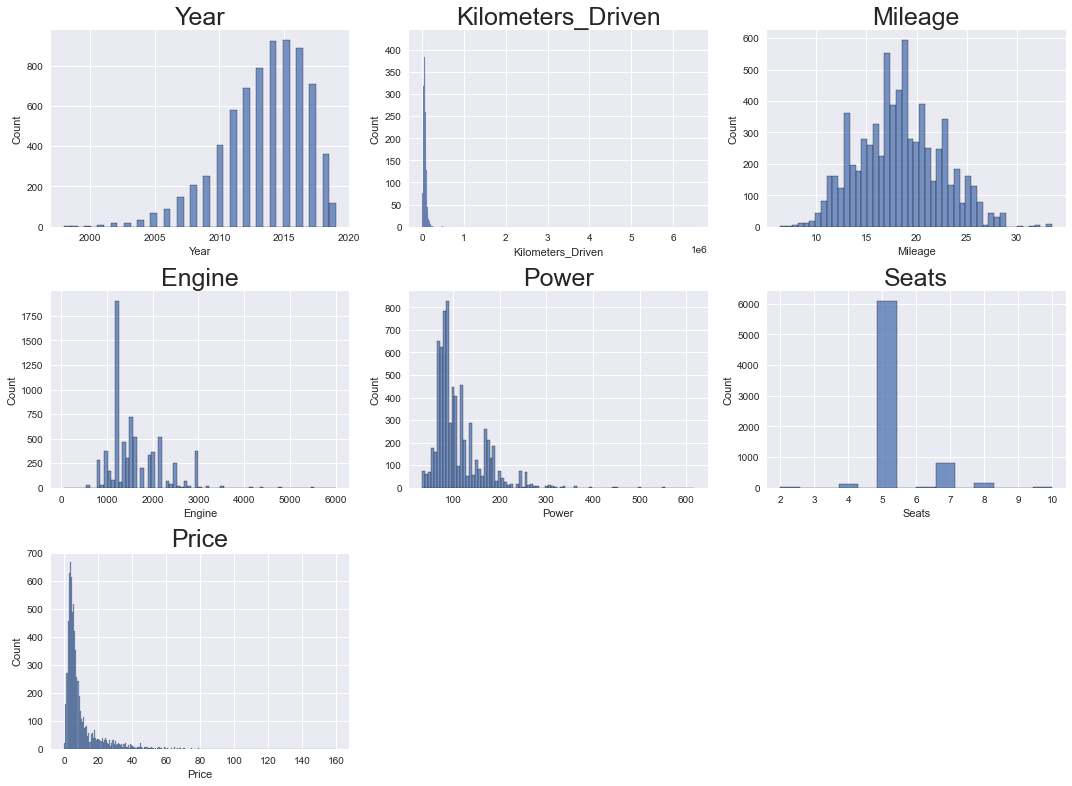

In [29]:
#Plotting histogram for distribution
Uni_num = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15,65))
 #creating a loop that will show the plots for the columns in one plot
for i in range(len(Uni_num)):    
    plt.subplot(18,3,i+1)
    sns.histplot(df[Uni_num[i]],kde=False)
    plt.tight_layout()
    plt.title(Uni_num[i],fontsize=25)

plt.show()

Analsyis of above and the below visualisations
Year: Left Skewed 
Kilometers driven: Right skewed spike
Mileage: Normal distribution 
Engine:Right skewed 
Power: Right skewed 
Seats: Right Skewed 

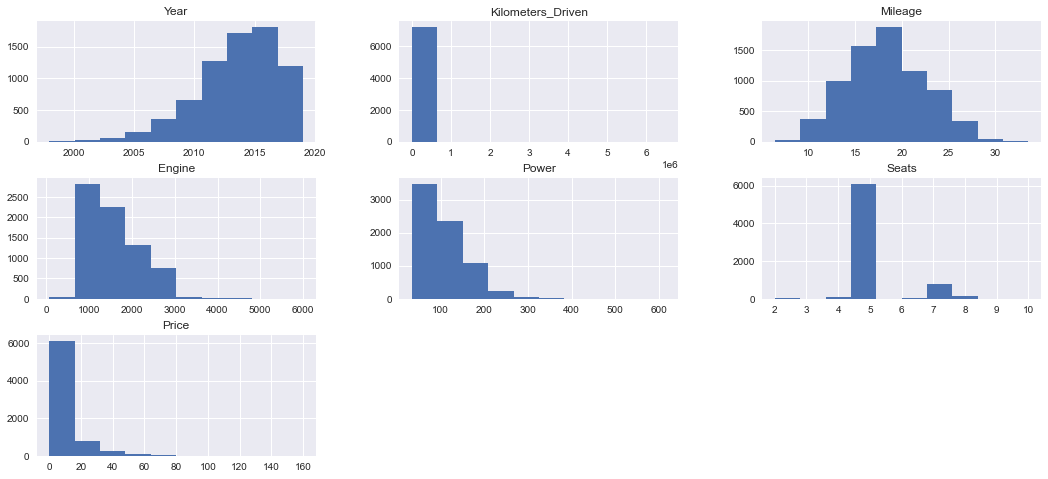

In [30]:
#Useful histogram to view any variances and understand the data set - note mileage presents normally 
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (18,8))
ax = fig.gca()
df.hist(ax = ax);

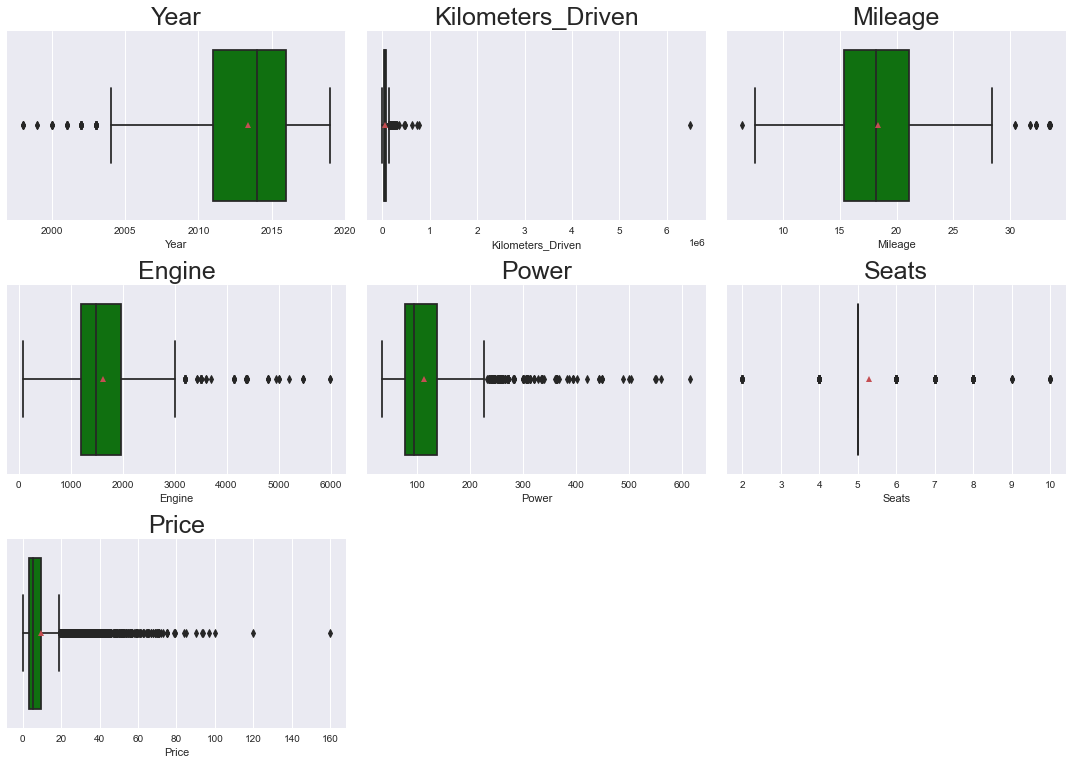

In [31]:
#Plotting a box plot to investigateparameters
plt.figure(figsize=(15,35))
for i in range(len(Uni_num)):
    plt.subplot(10,3,i+1)
    sns.boxplot(df[Uni_num[i]],showmeans=True, color='green')
    plt.tight_layout()
    plt.title(Uni_num[i],fontsize=25)
plt.show()

In [32]:
#Creating region lists
regions ={'Delhi':'North','Jaipur':'North',
          'Chennai':'South','Coimbatore':'South','Hyderabad':'South','Bangalore':'South','Kochi':'South',
        'Kolkata':'East',
         'Mumbai':'West','Pune':'West','Ahmedabad':'West'}
df['Region']=df['Location'].replace(regions)

In [33]:
#dropping unnecessary models  & counting valid car type values to classify by level 
df.drop(["Car_Brand","Model"],axis=1,inplace=True)
df['Car_Type'] = pd.cut(df['Price'],[-np.inf,5.5,10.5,20.5,45.0,75.0,np.inf],
                       labels=["Level1","Level2","Level3","Level4","Level5","Level6"])

df['Car_Type'].value_counts()

## lEVELS = CAR_TYPE Level 1 is low grade(economical less expensive car) to Level 6 High grade (luxurious car) based on price. 
## Owner Type = First second cars, second card, third car, etc. 

Level1    3638
Level2    1916
Level3     896
Level4     669
Level5     120
Level6      12
Name: Car_Type, dtype: int64

In [34]:
#View sample of Level 3 type vehicle below 
df.sample()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Region,Car_Type
1222,Mahindra Scorpio VLX 2.2 mHawk BSIII,Coimbatore,2012,62729,Diesel,Manual,First,12.050,2179.000,120.000,8.000,6.320,South,Level2


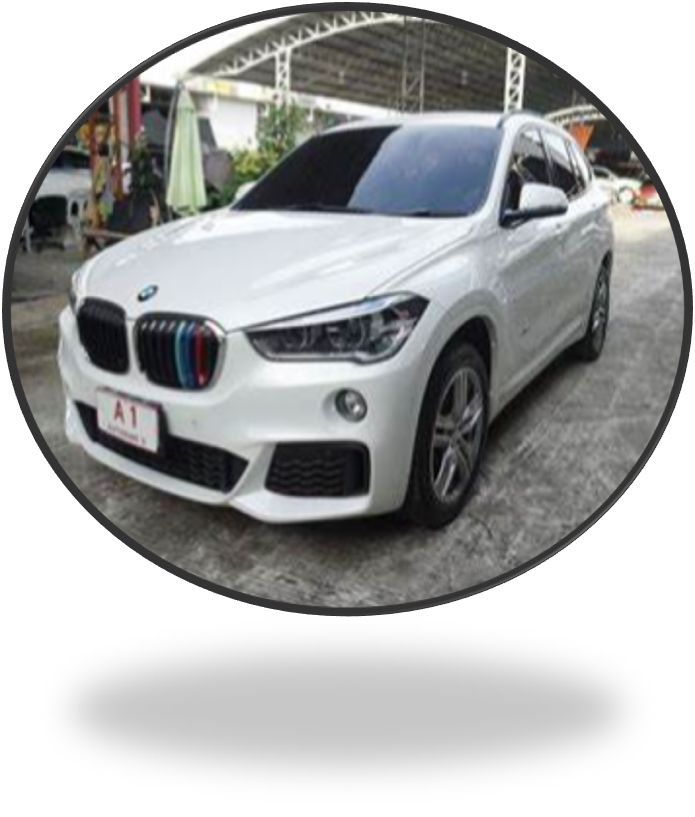

In [35]:
#set categorical values to craete column list
categorical_val = df.select_dtypes(exclude=np.number).columns.tolist()
categorical_val.remove('Name')
categorical_val.remove('Location')

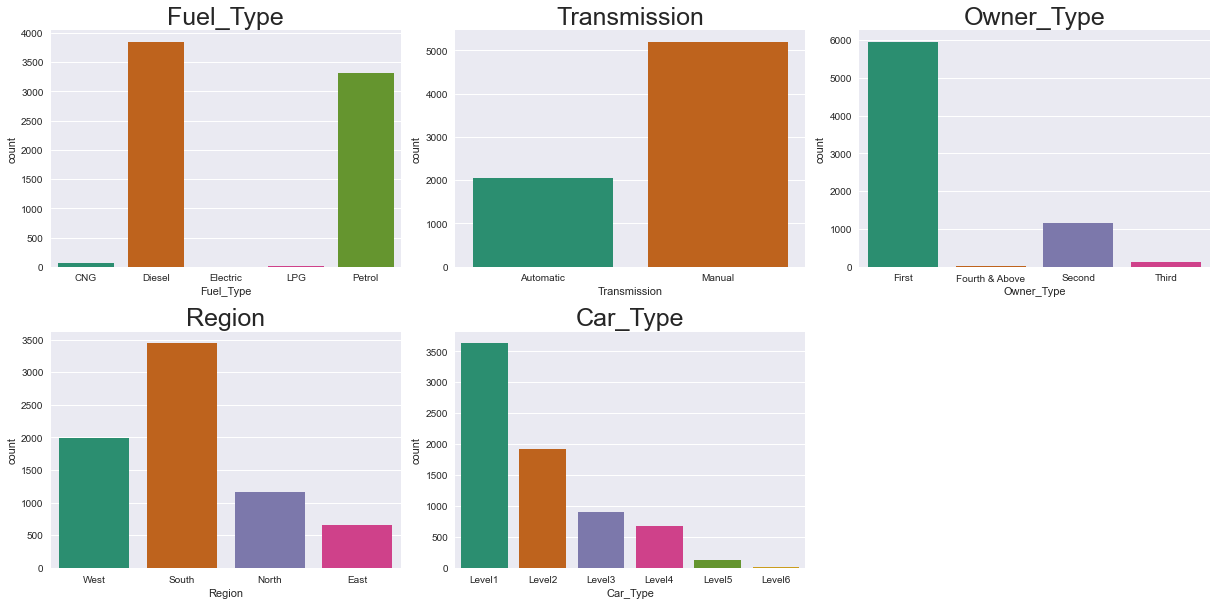

In [36]:
#visual bar graph
plt.figure(figsize=(17,75))
for i in range(len(categorical_val)):    
    plt.subplot(18,3,i+1)
    ax=sns.countplot(df[categorical_val[i]],palette='Dark2')
    plt.tight_layout()
    plt.title(categorical_val[i],fontsize=25)
    total = len (df[categorical_val[i]])
    for p in ax.patches:
        x = p.get_x() + (p.get_width() / 2)-0.1  
        y = p.get_y() + p.get_height()          
plt.show()

In [37]:
#Reviewing dataset for electric cars
df[df['Fuel_Type']=='Electric']

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Region,Car_Type
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,18.200,72.000,41.000,5.000,13.000,South,Level3
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,18.200,1798.000,73.000,5.000,12.750,West,Level3


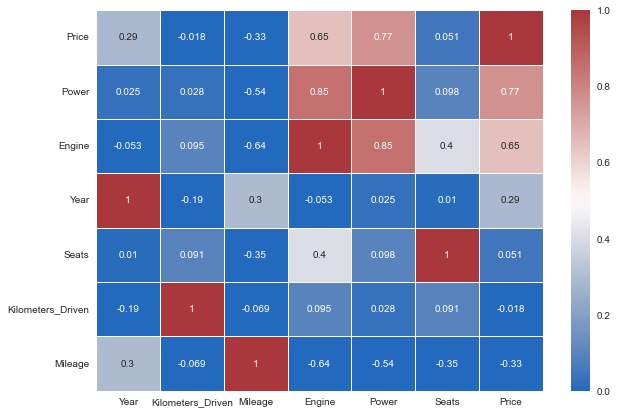

In [38]:
#heat map showing strongest correlations
corr= df.corr().sort_values(by=['Price'],ascending=False) 
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot= True,vmin=0,vmax=1, cmap='vlag',linewidths=0.75)
plt.show()
#Price & Power = .77
#Power & Engine = .85


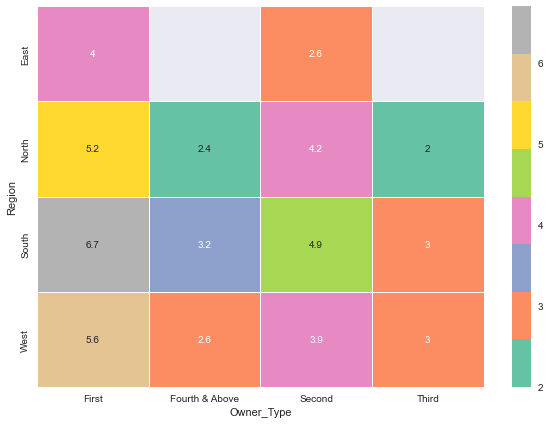

In [39]:
#Does type of ownership affect Car price?
df_hm =df.pivot_table(index = 'Region',columns ='Owner_Type',values ="Price",aggfunc=np.median)
# Heatmap to display 
plt.subplots(figsize=(10,7))
sns.heatmap(df_hm,cmap='Set2',linewidths=.5, annot=True);
#south Region purchases more second hand cars 


## Step 3: Test for the linearity assumption 

Using scatterplots, heatmaps, bar graphs to plot each predictor against the target variable

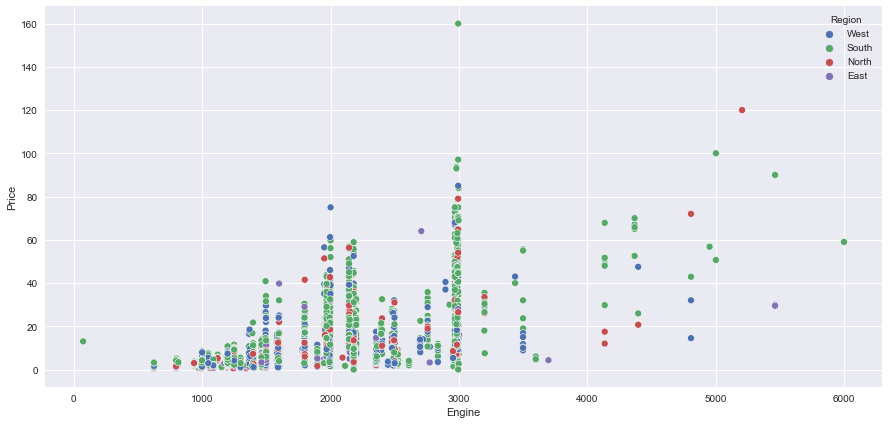

In [40]:
#Analysis of variables that have high correlation with Price
#Price Vs Engine Vs Region
plt.figure(figsize=(15,7))
sns.scatterplot(data=df,y='Price',x='Engine',hue='Region')
plt.show()

<AxesSubplot:xlabel='Engine', ylabel='Price'>

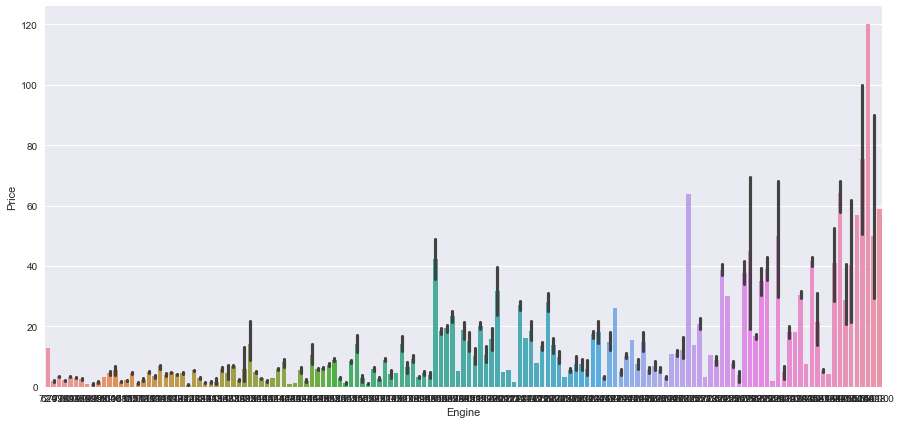

In [41]:
#Does type of Fuel affect car price?
plt.figure(figsize=(15,7))
sns.barplot(data=df,x='Engine',y='Price')

<AxesSubplot:xlabel='Fuel_Type', ylabel='Price'>

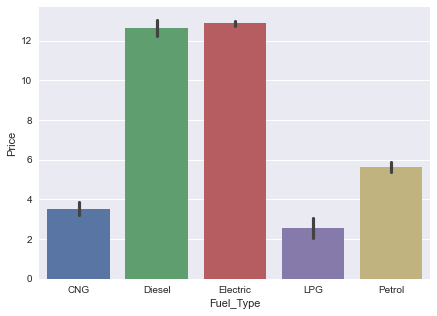

In [42]:
#Does type of Fuel affect car price?
plt.figure(figsize=(7,5))
sns.barplot(data=df,x='Fuel_Type',y='Price')

# Step 7: Visualize the error term for variance and heteroscedasticity

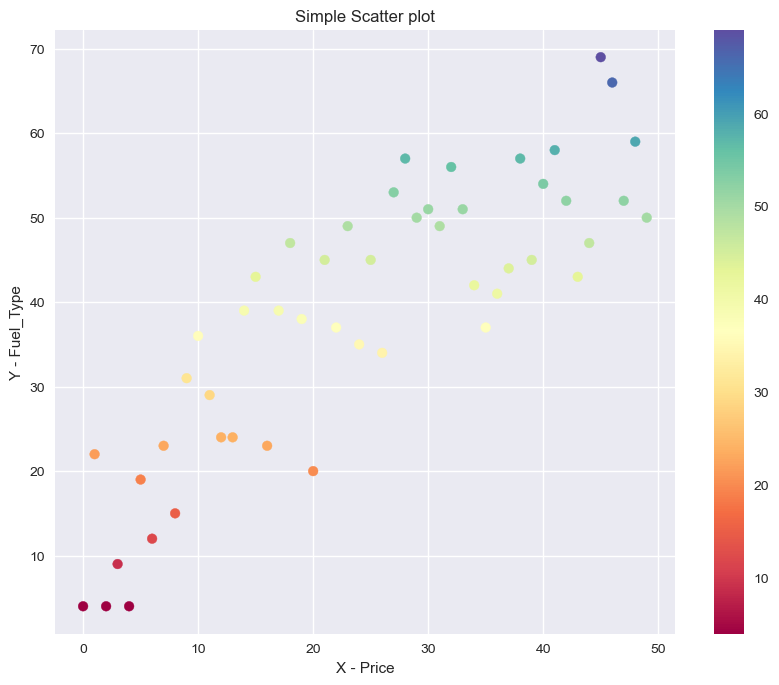

In [43]:
# Simple Scatterplot with colored points
x = range(50)
y = range(50) + np.random.randint(0,30,50)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.title('Simple Scatter plot')
plt.xlabel('X - Price')
plt.ylabel('Y - Fuel_Type')
plt.show()

In [44]:
#Dealing with outliers utilisng the 25th & 75th quantiles 
def treat_outliers(df,col):
   
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)  
                                                            
    return df

def treat_outliers_all(df, col_list):
    
    for c in col_list:
        df = treat_outliers(df,c)     
    return df    

In [45]:
#making a first copy
#Dropping Year,Mileage and Seats irrelevant due to outliers
df2=df.copy() 
numerical_col = df2.select_dtypes(include=np.number).columns.tolist()
numerical_col.remove('Year')
numerical_col.remove('Mileage')
numerical_col.remove('Seats')  
numerical_col

['Kilometers_Driven', 'Engine', 'Power', 'Price']

In [46]:
#dealing with outliers 
df2 = treat_outliers_all(df2,numerical_col) 

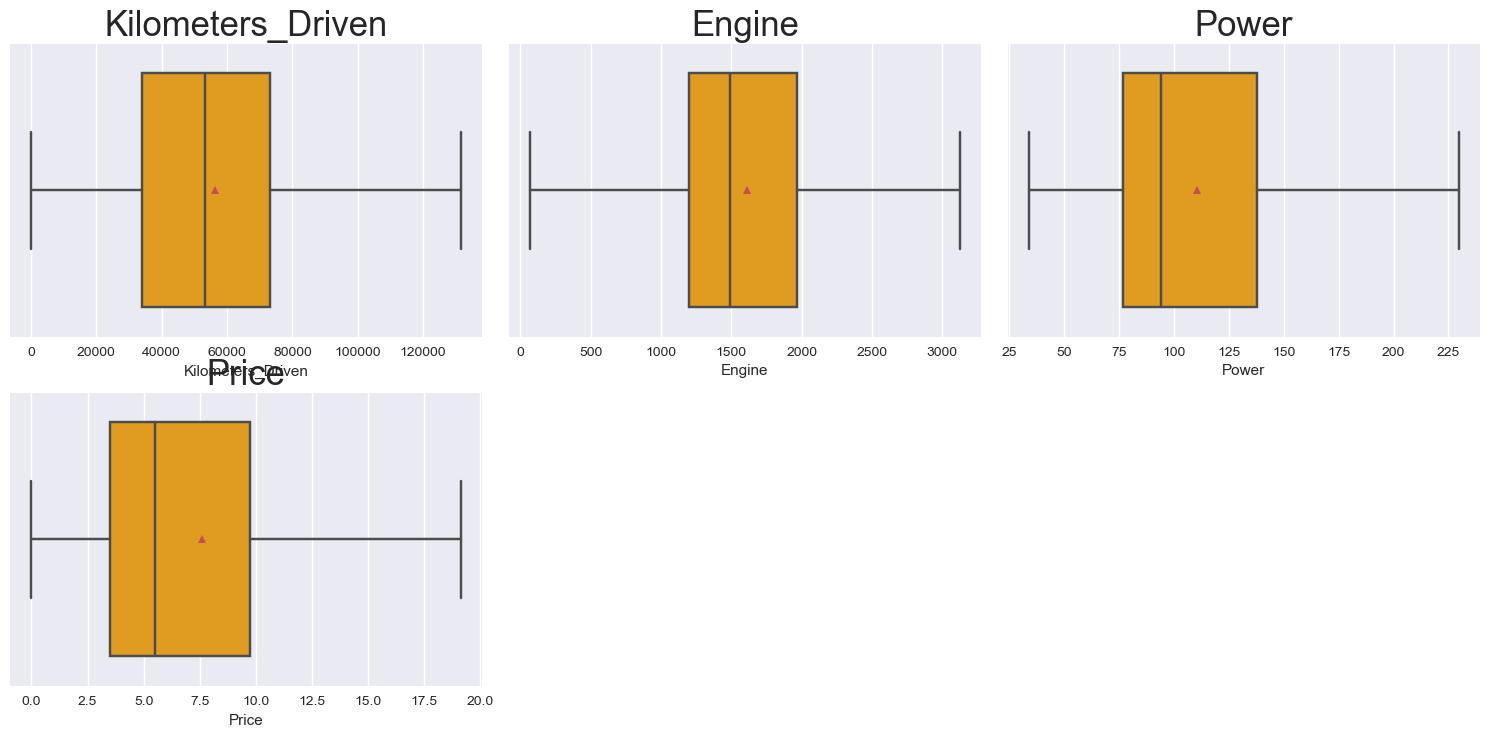

In [47]:
#checking if the outliers have applied 
plt.figure(figsize=(15,35))
for i in range(len(numerical_col)):
    plt.subplot(10,3,i+1)
    sns.boxplot(df2[numerical_col[i]],showmeans=True, color='orange')
    plt.tight_layout()
    plt.title(numerical_col[i],fontsize=25)
plt.show()

In [48]:
#Reviewing data head
df2.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Region,Car_Type
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000.000,CNG,Manual,First,26.600,998.000,58.160,5.000,1.750,West,Level1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000.000,Diesel,Manual,First,19.670,1582.000,126.200,5.000,12.500,West,Level3
2,Honda Jazz V,Chennai,2011,46000.000,Petrol,Manual,First,18.200,1199.000,88.700,5.000,4.500,South,Level1
3,Maruti Ertiga VDI,Chennai,2012,87000.000,Diesel,Manual,First,20.770,1248.000,88.760,7.000,6.000,South,Level2
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670.000,Diesel,Automatic,Second,15.200,1968.000,140.800,5.000,17.740,South,Level3


In [49]:
#dropping Name as we have created a bin called: Car_Type
#dropping Fuel_Type 
X = df2.drop(['Name','Fuel_Type','Location','Price'], axis=1)
y = df2[['Price']]
#Reviewing new data shape
print(X.shape)
print(y.shape)

(7251, 10)
(7251, 1)


In [50]:
#Creating Dummy Variabls for the Categorical Columns
#Dummy variable will be used as independent variables and will not impose any ranking
X = pd.get_dummies(X, columns=['Transmission','Owner_Type','Region','Car_Type'], drop_first=True)
X.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Region_North,Region_South,Region_West,Car_Type_Level2,Car_Type_Level3,Car_Type_Level4,Car_Type_Level5,Car_Type_Level6
0,2010,72000.000,26.600,998.000,58.160,5.000,1,0,0,0,0,0,1,0,0,0,0,0
1,2015,41000.000,19.670,1582.000,126.200,5.000,1,0,0,0,0,0,1,0,1,0,0,0
2,2011,46000.000,18.200,1199.000,88.700,5.000,1,0,0,0,0,1,0,0,0,0,0,0
3,2012,87000.000,20.770,1248.000,88.760,7.000,1,0,0,0,0,1,0,1,0,0,0,0
4,2013,40670.000,15.200,1968.000,140.800,5.000,0,0,1,0,0,1,0,0,1,0,0,0


In [51]:
#split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56) # keeping random_state =56 ensuring datasplit remains consistent
X_train.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Region_North,Region_South,Region_West,Car_Type_Level2,Car_Type_Level3,Car_Type_Level4,Car_Type_Level5,Car_Type_Level6
1928,2016,55100.000,17.010,1582.000,126.200,5.000,0,0,0,0,0,0,1,0,1,0,0,0
6278,2012,90000.000,23.590,1364.000,94.000,5.000,1,0,0,0,0,1,0,0,0,0,0,0
22,2015,55985.000,13.530,1984.000,177.010,5.000,0,0,0,0,0,0,1,0,0,1,0,0
5925,2010,85000.000,17.500,1798.000,94.000,5.000,1,0,0,0,0,0,1,0,0,0,0,0
5762,2014,51000.000,27.030,1969.000,190.000,5.000,0,0,0,0,0,1,0,0,0,1,0,0


In [52]:
#Fitting linear model
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()                                    
linearregression.fit(X_train, y_train)
print("Intercept of the linear equation:", linearregression.intercept_) 
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, linearregression.coef_[0][idx]))

Intercept of the linear equation: [-404.87654936]
The coefficient for Year is 0.2014249816152108
The coefficient for Kilometers_Driven is -1.6203755332221522e-06
The coefficient for Mileage is 0.04349748263039035
The coefficient for Engine is 0.0007955011277483669
The coefficient for Power is 0.016005440241528498
The coefficient for Seats is 0.07091913468838472
The coefficient for Transmission_Manual is -0.7422961502300802
The coefficient for Owner_Type_Fourth & Above is 0.5406481259194158
The coefficient for Owner_Type_Second is -0.09782155395636072
The coefficient for Owner_Type_Third is -0.23169983508213976
The coefficient for Region_North is 0.21245763647508623
The coefficient for Region_South is 0.3898811409975626
The coefficient for Region_West is 0.26965728280936585
The coefficient for Car_Type_Level2 is 2.6033256086328653
The coefficient for Car_Type_Level3 is 8.598665328915168
The coefficient for Car_Type_Level4 is 12.04933176079081
The coefficient for Car_Type_Level5 is 10.89

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pred = linearregression.predict(X_test) 

In [54]:
# Mean Absolute Error on test
mean_absolute_error(y_test, pred)

0.8903015607952957

In [55]:
# RMSE on test data
mean_squared_error(y_test, pred)**0.5

1.215184412886623

In [56]:
# R-squared on test
r2_score(y_test, pred)

0.9536193921069149

In [57]:
#Calculating train score
linearregression.score(X_train, y_train)  # 70 % data 

0.9520061630151408

In [58]:
#Calculating Test Score
linearregression.score(X_test, y_test) # unseen data

0.9536193921069149

In [59]:
#Creating another copy of df
df3=df.copy() 
df3.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Region,Car_Type
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.600,998.000,58.160,5.000,1.750,West,Level1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.670,1582.000,126.200,5.000,12.500,West,Level3
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.200,1199.000,88.700,5.000,4.500,South,Level1
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.770,1248.000,88.760,7.000,6.000,South,Level2
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.200,1968.000,140.800,5.000,17.740,South,Level3


In [60]:
#Creating additional variable to drop unnecessary columns 
X1 = df3.drop(['Name','Fuel_Type','Location','Price'], axis=1)
y1 = df3[['Price']]

print(X1.shape)
print(y1.shape)

(7251, 10)
(7251, 1)


In [61]:
#Creating Dummy Variables for categorical columns
X1 = pd.get_dummies(X1, columns=['Region','Car_Type','Transmission','Owner_Type'], drop_first=True)
X1.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Region_North,Region_South,Region_West,Car_Type_Level2,Car_Type_Level3,Car_Type_Level4,Car_Type_Level5,Car_Type_Level6,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2010,72000,26.600,998.000,58.160,5.000,0,0,1,0,0,0,0,0,1,0,0,0
1,2015,41000,19.670,1582.000,126.200,5.000,0,0,1,0,1,0,0,0,1,0,0,0
2,2011,46000,18.200,1199.000,88.700,5.000,0,1,0,0,0,0,0,0,1,0,0,0
3,2012,87000,20.770,1248.000,88.760,7.000,0,1,0,1,0,0,0,0,1,0,0,0
4,2013,40670,15.200,1968.000,140.800,5.000,0,1,0,0,1,0,0,0,0,0,1,0


In [62]:
#split the data into train and test
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=56)
X1_train.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Region_North,Region_South,Region_West,Car_Type_Level2,Car_Type_Level3,Car_Type_Level4,Car_Type_Level5,Car_Type_Level6,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
1928,2016,55100,17.010,1582.000,126.200,5.000,0,0,1,0,1,0,0,0,0,0,0,0
6278,2012,90000,23.590,1364.000,94.000,5.000,0,1,0,0,0,0,0,0,1,0,0,0
22,2015,55985,13.530,1984.000,177.010,5.000,0,0,1,0,0,1,0,0,0,0,0,0
5925,2010,85000,17.500,1798.000,94.000,5.000,0,0,1,0,0,0,0,0,1,0,0,0
5762,2014,51000,27.030,1969.000,190.000,5.000,0,1,0,0,0,1,0,0,0,0,0,0


In [63]:
#Fitting linear model
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()                                    
linearregression.fit(X1_train, y1_train)                                  
print('Intercept of the linear equation:', linearregression.intercept_) 
for idx, col_name in enumerate(X1_train.columns):
    print("The coefficient for {} is {}".format(col_name, linearregression.coef_[0][idx]))    

Intercept of the linear equation: [-559.64477119]
The coefficient for Year is 0.27815207711649104
The coefficient for Kilometers_Driven is -3.933049214243794e-06
The coefficient for Mileage is 0.041173020980351936
The coefficient for Engine is 0.0012536524615097344
The coefficient for Power is 0.021857197060797674
The coefficient for Seats is -0.10443213439518366
The coefficient for Region_North is 0.43423501867368897
The coefficient for Region_South is 0.6551430985061976
The coefficient for Region_West is 0.3849291968220981
The coefficient for Car_Type_Level2 is 2.18734590987969
The coefficient for Car_Type_Level3 is 7.852889631704657
The coefficient for Car_Type_Level4 is 21.448157673682097
The coefficient for Car_Type_Level5 is 45.73101094812465
The coefficient for Car_Type_Level6 is 77.34107051395367
The coefficient for Transmission_Manual is -0.5553857640064356
The coefficient for Owner_Type_Fourth & Above is 1.060293629823952
The coefficient for Owner_Type_Second is -0.0121761330

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pred1 = linearregression.predict(X1_test)

In [65]:
# Calculate MAE 
mean_absolute_error(y1_test, pred1)

1.5128627827869912

In [66]:
#Calculate RMSE
mean_squared_error(y1_test, pred1)**0.5

3.093684570463301

In [67]:
#Calculate R2 Score
r2_score(y1_test, pred1)

0.921506918435542

In [68]:
#Calculate training lr Score based on 70% training data
linearregression.score(X1_train, y1_train)

0.9450553498559194

The above appears to be a good fit to model predictions at 94%

In [69]:
#calculate lr score
linearregression.score(X1_test, y1_test) 

0.921506918435542

# Run a OLS regression in Statsmodels with multiple variables in test data 

In [70]:
# Builing first OLS stats model
import statsmodels.api as sm
X = sm.add_constant(X)
X_train1, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

olsmod0 = sm.OLS(y_train, X_train1) 
olsres0 = olsmod0.fit()
print(olsres0.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     5572.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:30:23   Log-Likelihood:                -8236.5
No. Observations:                5075   AIC:                         1.651e+04
Df Residuals:                    5056   BIC:                         1.664e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [71]:
#statsmodels.stats.outliers_influence.variance - A measure for multicollinearity of the design matrix, exog.VIF = Variance inflation factor 
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_series1 = pd.Series([variance_inflation_factor(X_train1.values,i) for i in range(X_train1.shape[1])],index=X_train1.columns)
print('Train Model 1: \n\n{}\n'.format(vif_series1))

Train Model 1: 

const                       843215.673
Year                             2.198
Kilometers_Driven                1.688
Mileage                          2.122
Engine                           6.520
Power                            7.102
Seats                            1.818
Transmission_Manual              2.120
Owner_Type_Fourth & Above        1.013
Owner_Type_Second                1.139
Owner_Type_Third                 1.077
Region_North                     2.482
Region_South                     3.654
Region_West                      3.109
Car_Type_Level2                  1.669
Car_Type_Level3                  2.284
Car_Type_Level4                  3.052
Car_Type_Level5                  1.641
Car_Type_Level6                  1.116
dtype: float64



In [72]:
#training second model to display values
X_train2 = X_train1.drop('Power', axis=1)
vif_series2 = pd.Series([variance_inflation_factor(X_train2.values,i) for i in range(X_train2.shape[1])],index=X_train2.columns)
print('Train Model 2: \n\n{}\n'.format(vif_series2))

Train Model 2: 

const                       841255.110
Year                             2.194
Kilometers_Driven                1.688
Mileage                          2.093
Engine                           3.925
Seats                            1.625
Transmission_Manual              1.957
Owner_Type_Fourth & Above        1.012
Owner_Type_Second                1.138
Owner_Type_Third                 1.077
Region_North                     2.480
Region_South                     3.638
Region_West                      3.106
Car_Type_Level2                  1.586
Car_Type_Level3                  2.077
Car_Type_Level4                  2.577
Car_Type_Level5                  1.532
Car_Type_Level6                  1.107
dtype: float64



# Get Regression Diagnostics Summary

In [73]:
#OLS model - depicting values
olsmod1 = sm.OLS(y_train, X_train2)
olsres1 = olsmod1.fit()
print(olsres1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     5601.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:30:23   Log-Likelihood:                -8362.3
No. Observations:                5075   AIC:                         1.676e+04
Df Residuals:                    5057   BIC:                         1.688e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [74]:
#Running third model - depicting values
X_train3 = X_train1.drop('Engine', axis=1)
vif_series3 = pd.Series([variance_inflation_factor(X_train3.values,i) for i in range(X_train3.shape[1])],index=X_train3.columns)
print('Train Model 3: \n\n{}\n'.format(vif_series3))

Train Model 3: 

const                       841834.515
Year                             2.195
Kilometers_Driven                1.625
Mileage                          2.013
Power                            4.275
Seats                            1.401
Transmission_Manual              2.114
Owner_Type_Fourth & Above        1.012
Owner_Type_Second                1.138
Owner_Type_Third                 1.077
Region_North                     2.478
Region_South                     3.647
Region_West                      3.102
Car_Type_Level2                  1.647
Car_Type_Level3                  2.235
Car_Type_Level4                  3.010
Car_Type_Level5                  1.590
Car_Type_Level6                  1.096
dtype: float64



In [75]:
#Running OLS 
olsmod2 = sm.OLS(y_train, X_train3)
olsres2 = olsmod2.fit()
print(olsres2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     5775.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:30:23   Log-Likelihood:                -8288.4
No. Observations:                5075   AIC:                         1.661e+04
Df Residuals:                    5057   BIC:                         1.673e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [76]:
#Running OLS
X_train4 = X_train3.drop('Kilometers_Driven', axis=1)
olsmod3 = sm.OLS(y_train, X_train4)
olsres3 = olsmod3.fit()
print(olsres3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     6137.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:30:23   Log-Likelihood:                -8288.4
No. Observations:                5075   AIC:                         1.661e+04
Df Residuals:                    5058   BIC:                         1.672e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [77]:
residual= olsres3.resid
np.mean(residual)

-1.3657719946781153e-12

In [89]:
#predicted values
residual=olsres3.resid
fitted=olsres3.fittedvalues

Regression Results:
Adjusted. R-squared: Model fit between the range of 0 to 1
A high Adjusted R-Squared value of 0.953 indicates good fit. 

Const coefficient is the Y-intercept with  -40.48
Std err:  coefficients reflect high accuracy 
P >|t|: It is p-value.

This shows that for each independent feature there is a null hypothesis and alternate hypothesis

Ho : Independent variable is not significant

Ha : Independent variable is significant

If p-value is less than 0.05 , then the variable is considered to be statistically significant.

Confidence Interval 95%: It represents the range in which our coefficients are likely to fall.

# Draw a prediction line with data points on a scatter plot Showing Residuals Best Fit 

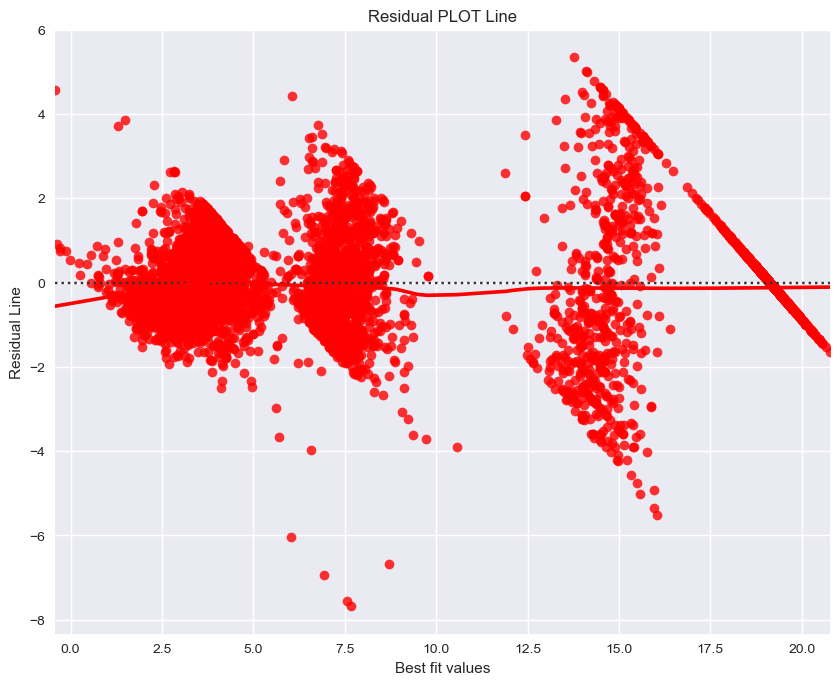

In [79]:
#Graph mapping residual best plot / line of fit 
sns.set_style("darkgrid")
sns.residplot(fitted,residual,color="red",lowess=True)
plt.xlabel("Best fit values")
plt.ylabel("Residual Line")
plt.title("Residual PLOT Line")
plt.show()

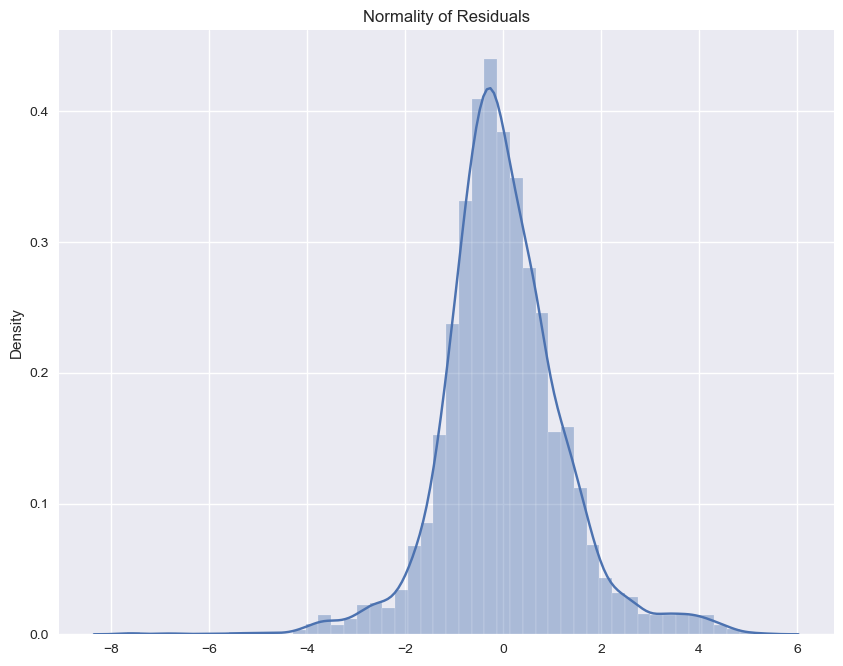

In [80]:
#Histogram of Residuals
sns.distplot(residual) 
plt.title('Normality of Residuals')
plt.show()

# Check the normality assumptions by creating a QQ-plot

QQ Plot shows linearity see below

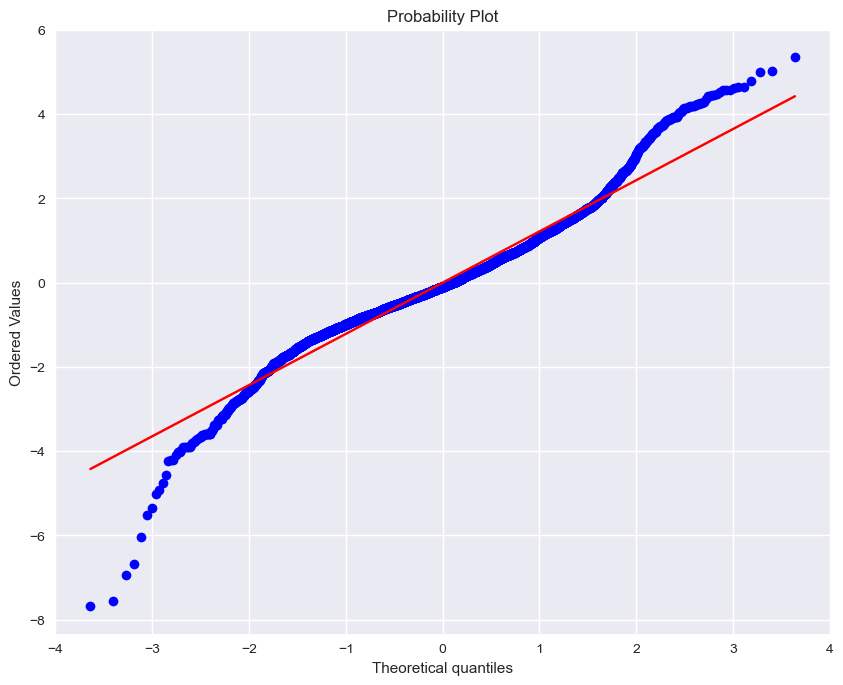

In [81]:
# Q-Q plot to check the normal probability of residuals.
import pylab
import scipy.stats as stats
stats.probplot(residual,dist="norm",plot=pylab)
plt.show()

In [82]:
#Obtain F statistic and P values 
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residual, X_train4)
lzip(name, test)

[('F statistic', 1.033807218416428), ('p-value', 0.20199670346246976)]

## Model Data for Prediction 

In [83]:
#Clarify x train column detail
X_train4.columns

Index(['const', 'Year', 'Mileage', 'Power', 'Seats', 'Transmission_Manual',
       'Owner_Type_Fourth & Above', 'Owner_Type_Second', 'Owner_Type_Third',
       'Region_North', 'Region_South', 'Region_West', 'Car_Type_Level2',
       'Car_Type_Level3', 'Car_Type_Level4', 'Car_Type_Level5',
       'Car_Type_Level6'],
      dtype='object')

In [84]:
#Print x train head
X_test_final = X_test[X_train4.columns]
X_test_final.head()

,const,Year,Mileage,Power,Seats,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Region_North,Region_South,Region_West,Car_Type_Level2,Car_Type_Level3,Car_Type_Level4,Car_Type_Level5,Car_Type_Level6
1083,1.000,2015,21.430,87.200,5.000,1,0,0,0,0,0,0,1,0,0,0,0
4601,1.000,2019,20.680,190.000,5.000,0,0,0,0,0,1,0,0,0,1,0,0
1969,1.000,2011,12.400,132.000,8.000,1,0,0,0,0,0,0,1,0,0,0,0
5344,1.000,2015,18.600,81.830,5.000,1,0,0,0,0,1,0,0,0,0,0,0
2056,1.000,2015,16.770,229.575,5.000,0,0,1,0,0,1,0,0,0,1,0,0


In [85]:
#set variable predictor value 
y_pred = olsres3.predict(X_test_final)

# Cross Validation Using Sci-kit Learn

In [86]:
#Checking root mean squared error for train and test set  
rms = np.sqrt(mean_squared_error(y_train, fitted))
print('Train error:',rms)
rms1 = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test error:',rms1)

Train error: 1.2389217848929732
Test error: 1.2327474340985183


Train and test values are very low, yet is not over / under fitting. 


In [87]:
#final train test
olsmodtest = sm.OLS(y_test, X_test_final)
olsrestest = olsmodtest.fit()
print(olsrestest.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     2720.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:30:26   Log-Likelihood:                -3532.1
No. Observations:                2176   AIC:                             7098.
Df Residuals:                    2159   BIC:                             7195.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [88]:
#print trained OLS model 
print(olsres3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     6137.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:30:26   Log-Likelihood:                -8288.4
No. Observations:                5075   AIC:                         1.661e+04
Df Residuals:                    5058   BIC:                         1.672e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

##Conclusion:
    
Main impacts to buying Used cars: 

-The Ordinary Least Squares is a good model for prediction and inference at 95.1% adjusted Rsquared value.
-Transmission and Owner type depict negative correlation to Price. 
-Automatic transmissions tend to be more expensive and manuals sell for less according to this model. 
-The year, mileage, power and number of seats have shown a positive assosiation with sale price. 